In [23]:
%%capture
!pip install transformers datasets tabulate

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

In [25]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm import tqdm
from transformers import BertTokenizer

The goal of this lab session is to implement the model proposed by  Yoon Kim, published in 2014. The original paper can be found [here](https://www.aclweb.org/anthology/D14-1181).
Of course, there exists pytorch and tensorflow implementations on the web. They are more or less correct and efficient. However, here it is important to do it yourself. The goal is to better understand pytorch and the convolution.

The road-map is to:
- Handle the data in the pytorch way
- Implement the convolution and pooling
- Add dropout on the last layer




# Data loading

In pytorch data handling is done in 3 steps: 
- Tokenizer (splitting a strings into a list of smaller substrings called tokens).
- Dataset  (a class to access the raw data)
- Dataloader (the class to iterate through the dataset and to get access to well prepared batch of data)

From the model viewpoint: 
- during training and testing you interact with the Dataloader
- the dataloader uses a DataCollator (on the fly) to each batch of data
- the DataCollator calls the tokenizer to process the data. 


In [26]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). Depending on the language, the sources, and the domain, the tokenization can be very important. When you start from raw texts, it is always crucial to spend (and not waste) a lot of time to clean the data. 

Here we will use an already built tokenizer.  It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [27]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

🚧 **Question** 🚧

What it is this object? Find the documentation about HuggingFace tokenizer and refer to it for the next cells.

**Answer**

In the next cells we are going to experiment with this object. The following line of codes should help you better understand the `Tokenizer`.

In [28]:
print("Type of the tokenizer:", type(tokenizer.vocab))
VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)
print(str(tokenizer.vocab)[:100])

Type of the tokenizer: <class 'collections.OrderedDict'>
Length of the vocabulary: 30522
OrderedDict([('[PAD]', 0), ('[unused0]', 1), ('[unused1]', 2), ('[unused2]', 3), ('[unused3]', 4), (


In [29]:
def print_sentence(sent):
    """Displays the tokens and respective IDs of a text sample"""
    table = np.array(
        [
            tokenizer.tokenize(sent),
            tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent)),
        ]
    ).T
    print(tabulate(table, headers=["Tokens", "Token IDs"], tablefmt="fancy_grid"))


sample = dataset[0]
print_sentence(sample["review"])
print("The label:", sample["sentiment"])

╒═══════════════╤═════════════╕
│ Tokens        │   Token IDs │
╞═══════════════╪═════════════╡
│ one           │        2028 │
├───────────────┼─────────────┤
│ of            │        1997 │
├───────────────┼─────────────┤
│ the           │        1996 │
├───────────────┼─────────────┤
│ other         │        2060 │
├───────────────┼─────────────┤
│ reviewers     │       15814 │
├───────────────┼─────────────┤
│ has           │        2038 │
├───────────────┼─────────────┤
│ mentioned     │        3855 │
├───────────────┼─────────────┤
│ that          │        2008 │
├───────────────┼─────────────┤
│ after         │        2044 │
├───────────────┼─────────────┤
│ watching      │        3666 │
├───────────────┼─────────────┤
│ just          │        2074 │
├───────────────┼─────────────┤
│ 1             │        1015 │
├───────────────┼─────────────┤
│ oz            │       11472 │
├───────────────┼─────────────┤
│ episode       │        2792 │
├───────────────┼─────────────┤
│ you   

In [30]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [31]:
preprocessing_fn(dataset[5], tokenizer)

{'review': 'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.',
 'sentiment': 'positive',
 'review_ids': [2763,
  2026,
  2035,
  1011,
  2051,
  5440,
  3185,
  1010,
  1037,
  2466,
  1997,
  2969,
  24913,
  1010,
  8688,
  1998,
  12276,
  2000,
  1037,
  7015,
  3426,
  1010,
  2021,
  2009,
  1005,
  1055,
  2025,
  25250,
  2100,
  2030,
  11771,
  1012,
  2009,
  2074,
  2196,


Be sure, you understand this output.

Now we can really prepare the data for the NNet.

🚧 **TODO** 🚧

Read the documentation about HuggingFace dataset and complete the code below.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [32]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
sample = dataset.select(range(n_samples))

# Tokenize the dataset
dataset = sample.map(preprocessing_fn, fn_kwargs={"tokenizer": tokenizer})

# Remove useless columns
dataset = dataset.remove_columns(["review", "sentiment"])

# Split the train and validation
split = dataset.train_test_split(test_size=0.2)
train_set = split["train"]
valid_set = split["test"]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [33]:
print("Number of training examples:", len(train_set))
print("Number of validation examples:", len(valid_set))

Number of training examples: 4000
Number of validation examples: 1000


The dataset now outputs list of ids. However, there is one last remaining step. Since we want to have batch of tensors, they should have the same size.

Below is a code for padding batch of lists to the same size.

> 💡 *Note*: This process can be done a bit quicker with HuggingFace built-in `DataCollator` object, that tokenizes + pads at once. But since these objects can be a bit complex at first sight, we present here a custom equivalent method. Moreover, they use the same underlying processes than what we present here.

In [34]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

🚧 **Question** 🚧

We used the argument `padding="longest"`. What does it do? What are the other options?

Let's define the `DataLoaders`.

In [35]:
data_collator = DataCollator(tokenizer)

In [36]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

🚧 **TODO** 🚧

Let's see what everything does.

Print various information about one batch.

Explore the variables and understand what's inside.

In [37]:
batch = next(iter(train_dataloader))
print(batch.keys())
print(batch["review_ids"].shape)
print(batch["label"].shape)

dict_keys(['review_ids', 'label'])
torch.Size([32, 256])
torch.Size([32, 1])


# Convolution model
Now, we are done with the data and we have our interface for the model, but we need to build the model.
Here the sequence of operation the model will achieve:  
- Embedding
- Convolution (1D)
- Pooling
- Linear
Now the question is: how can do it in pytorch ?


This is easy since most of these operations are already implemented. The  difficult part of the work is dedicated to playing with dimensions. This is true for pytorch, as well as tensorflow. Moreover, things can be tricky if we want our model to work properly with mini-batch (and we want it).
We will go through everything step-by-step.

## Embedding layer

The goal is to store a set of real vectors associated to each symbol (word) in the vocabulary. The layer requires :
- num_embeddings: the vocabulary size or the number of words under consideration. Words are represented by an index (starting at 0)
- embedding_dim : the dimension of the continous space (or the word embeddings.


Implicitely a lookup matrix is created to store *num_embeddings* of *size embedding_dim*. Let start with dummy dimensions that will help us to see what happens.

🚧 **TODO** 🚧

Create an instance of `nn.Embeddings`, with a number of vocabulary equals to `VOCSIZE` and dimension `h1`.

In [38]:
h1 = 4  # dimension of embeddings, the input size for convolution
embedding_layer = nn.Embedding(VOCSIZE, h1)
print(embedding_layer)

Embedding(30522, 4)


🚧 **TODO** 🚧
- Extract the lookup matrix from the embedding layer and print its shape.

- Print the embeddings sequence of the first 2 sequences of the `batch` created above (it should be totally random!).

- Print the shape of the emebedding sequence of `batch["review_ids"]`.

In [39]:
# extract the lookup matrix
lookup_matrix = embedding_layer.weight.data
print(f'Lookup matrix shape: {lookup_matrix.shape}')
# print the embeddings of the first 2 sequences
print(f'Embeddings of the first 2 sequences: {lookup_matrix[batch["review_ids"]][:2]}')
# print the shape of the embeddings of the batch
print(f'Embeddings of the batch: {lookup_matrix[batch["review_ids"]].shape}')

Lookup matrix shape: torch.Size([30522, 4])
Embeddings of the first 2 sequences: tensor([[[ 1.7726,  1.1351, -0.4289,  1.6991],
         [ 0.3900, -1.7698, -1.5546, -0.7321],
         [ 0.3995, -0.4752, -0.6446, -0.2033],
         ...,
         [ 0.3780, -0.8241,  0.5142, -0.2553],
         [ 0.3780, -0.8241,  0.5142, -0.2553],
         [ 0.3780, -0.8241,  0.5142, -0.2553]],

        [[ 0.3335, -0.7122, -0.8475, -1.1064],
         [-0.5955,  0.0171, -1.4207,  1.1271],
         [-0.8108,  0.3485,  0.7581,  0.9146],
         ...,
         [ 1.0129,  0.0985, -0.9802, -0.1629],
         [ 1.4730,  0.2352,  0.3216,  1.1783],
         [-0.7465, -0.8401,  1.3599, -0.8256]]])
Embeddings of the batch: torch.Size([32, 256, 4])


## Convolution1D

Look at the documentation of the Conv1d layer. Read it carefully and try to completely understand the following code. A convolution layer expects a tensor as input, with the following dimensions *(B, D, L)*:
- B: size of the batch, the number of examples (here the number of sequences per batch).
- D: the dimension of the vectors for each time step
- L: the length of the input sequence (the number of tokens in the sequence).

🚧 **Question** 🚧
Is this shape directly compatible with our Embeddings layer defined above?

🚧 **TODO** 🚧

- Make sure the following code computing a convolution run and is consistent.
- Draw what happens to better understand the obtained dimensions.


In [40]:
convolution_layer = nn.Conv1d(in_channels=h1, out_channels=2, kernel_size=3)
sequence_embedding = embedding_layer(batch["review_ids"][:6])
convolution_output = convolution_layer(sequence_embedding.mT)

🚧 **TODO** 🚧

Now if we add another parameter for padding (set to 1). What do you observe ?
Play a bit with the *kernel_size* along with the *padding* to understand the interaction:
- try (kernel_size, padding) = (3, 1)
- (5,1) and (5,2)

🚧 **Question** 🚧
A convolution outputs a sequence. But in the end, we want a scalar for classification.
What do you propose for pooling? What should be the associated PyTorch class?

**Answer**

TODO

🚧 **TODO** 🚧

Write the `Conv1DClassifier`.
It should be the same architecture than in the article mentioned above, but with only 1 layer.

Use dropout.

In [41]:
class Conv1dClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(
            in_channels=embedding_dim,
            out_channels=feature_size,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(feature_size, 2)
        self.out = nn.Softmax(dim=1)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        conv = self.conv(embeddings.transpose(1, 2))
        pool = self.pool(conv).squeeze(2)  # (B, D, L) -> (B, D, 1) -> (B, D)
        logits = self.linear(pool)
        return self.out(logits)


"""class Conv1dClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_sizes=[3, 5, 7]):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=embedding_dim,
                        out_channels=feature_size,
                        kernel_size=kernel_size,
                    ),
                    nn.BatchNorm1d(feature_size),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool1d(1),
                )
                for kernel_size in kernel_sizes
            ]
        )
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(len(kernel_sizes) * feature_size, 1)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        convs = [conv(embeddings.transpose(1, 2)) for conv in self.convs]
        pools = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in convs]
        pool = torch.cat(pools, dim=1)
        logits = self.linear(pool)
        return F.softmax(logits, dim=1)"""

'class Conv1dClassifier(nn.Module):\n    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_sizes=[3, 5, 7]):\n        super().__init__()\n        self.embedding_dim = embedding_dim\n        self.feature_size = feature_size\n        self.embedding = nn.Embedding(vocab_size, embedding_dim)\n        self.convs = nn.ModuleList(\n            [\n                nn.Sequential(\n                    nn.Conv1d(\n                        in_channels=embedding_dim,\n                        out_channels=feature_size,\n                        kernel_size=kernel_size,\n                    ),\n                    nn.BatchNorm1d(feature_size),\n                    nn.ReLU(),\n                    nn.AdaptiveAvgPool1d(1),\n                )\n                for kernel_size in kernel_sizes\n            ]\n        )\n        self.dropout = nn.Dropout(0.5)\n        self.linear = nn.Linear(len(kernel_sizes) * feature_size, 1)\n\n    def forward(self, input_ids):\n        embeddings = self

🚧 **TODO** 🚧
Try the classifier on a random sequence.

In [42]:
random_inputs = torch.randint(0, VOCSIZE, (4, 100))
# Test the class: is everything in place:
# A first classifier is built like :
model = Conv1dClassifier(vocab_size=VOCSIZE, embedding_dim=25)
# The parameters of the classifier are randomly initialize, but we
# can use it on a sequence :
out = model(random_inputs)
print(out.shape)  # the output has 2 dimensions
print(out)

# It is correct ? If not, correct the class to get the expected result.

torch.Size([4, 2])
tensor([[0.5228, 0.4772],
        [0.5227, 0.4773],
        [0.5303, 0.4697],
        [0.5244, 0.4756]], grad_fn=<SoftmaxBackward0>)


# Training the model

To train the model, we need to define a loss function and an optimizer. For the moment we will rely on an online learning algorithm: online stochastic gradient descent.
- we pick one training example
- compute the loss
- back-propagation of the gradient
- update of the parameters


At the end of one epoch, we evaluate the model on the validation step.

🚧 **TODO** 🚧

Write the training loop for the model.

- Choose the loss (not many choices here).
- Define the optimizer. Use whatever gradient-based algorithm you like (we recommend `torch.optim.Adam`)
- After the training loop, plot the evolution of the loss and accuracy.

In [43]:
# We redefine the DataLoader, in case you have modified it.
batch_size = 32
train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)

In [44]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

n_epochs = 20
epoch_train_losses = []
epoch_train_accs = []
epoch_val_losses = []
epoch_val_accs = []

mps_device = torch.device("mps")
model.to(mps_device)

for e in range(n_epochs):
    train_loss = 0.0
    train_corrects = 0
    total_train_samples = 0
    val_loss = 0.0
    val_corrects = 0
    total_val_samples = 0

    # Training
    model.train()
    for batch in tqdm(train_dataloader):
        inputs = batch["review_ids"].to(mps_device)
        labels = batch["label"].squeeze().to(mps_device)

        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_corrects += (logits.argmax(dim=1) == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_acc = train_corrects / total_train_samples
    epoch_train_losses.append(avg_train_loss)
    epoch_train_accs.append(avg_train_acc)

    # Validation
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            inputs = batch["review_ids"].to(mps_device)
            labels = batch["label"].squeeze().to(mps_device)
            logits = model(inputs)
            loss = loss_function(logits, labels)
            val_loss += loss.item()
            val_corrects += (logits.argmax(dim=1) == labels).sum().item()
            total_val_samples += labels.size(0)

    avg_val_loss = val_loss / len(valid_dataloader)
    avg_val_acc = val_corrects / total_val_samples
    epoch_val_losses.append(avg_val_loss)
    epoch_val_accs.append(avg_val_acc)

    print(
        f"Epoch {e + 1}/{n_epochs} - train loss: {avg_train_loss:.3f} - train acc: {avg_train_acc:.3f} - val loss: {avg_val_loss:.3f} - val acc: {avg_val_acc:.3f}"
    )

100%|██████████| 32/32 [00:00<00:00, 143.87it/s]


Epoch 1/20 - train loss: 0.692 - train acc: 0.506 - val loss: 0.690 - val acc: 0.548


100%|██████████| 32/32 [00:00<00:00, 144.75it/s]


Epoch 2/20 - train loss: 0.685 - train acc: 0.574 - val loss: 0.681 - val acc: 0.587


100%|██████████| 32/32 [00:00<00:00, 143.45it/s]


Epoch 3/20 - train loss: 0.662 - train acc: 0.646 - val loss: 0.660 - val acc: 0.627


100%|██████████| 32/32 [00:00<00:00, 143.44it/s]


Epoch 4/20 - train loss: 0.619 - train acc: 0.695 - val loss: 0.631 - val acc: 0.670


100%|██████████| 32/32 [00:00<00:00, 144.11it/s]


Epoch 5/20 - train loss: 0.578 - train acc: 0.743 - val loss: 0.606 - val acc: 0.693


100%|██████████| 32/32 [00:00<00:00, 142.14it/s]


Epoch 6/20 - train loss: 0.544 - train acc: 0.772 - val loss: 0.589 - val acc: 0.707


100%|██████████| 32/32 [00:00<00:00, 145.81it/s]


Epoch 7/20 - train loss: 0.517 - train acc: 0.800 - val loss: 0.576 - val acc: 0.717


100%|██████████| 32/32 [00:00<00:00, 145.58it/s]


Epoch 8/20 - train loss: 0.494 - train acc: 0.826 - val loss: 0.566 - val acc: 0.722


100%|██████████| 32/32 [00:00<00:00, 145.78it/s]


Epoch 9/20 - train loss: 0.474 - train acc: 0.847 - val loss: 0.558 - val acc: 0.734


100%|██████████| 32/32 [00:00<00:00, 144.68it/s]


Epoch 10/20 - train loss: 0.457 - train acc: 0.865 - val loss: 0.552 - val acc: 0.743


100%|██████████| 32/32 [00:00<00:00, 145.73it/s]


Epoch 11/20 - train loss: 0.442 - train acc: 0.880 - val loss: 0.546 - val acc: 0.749


100%|██████████| 32/32 [00:00<00:00, 144.63it/s]


Epoch 12/20 - train loss: 0.429 - train acc: 0.894 - val loss: 0.542 - val acc: 0.755


100%|██████████| 32/32 [00:00<00:00, 142.95it/s]


Epoch 13/20 - train loss: 0.417 - train acc: 0.906 - val loss: 0.538 - val acc: 0.762


100%|██████████| 32/32 [00:00<00:00, 145.58it/s]


Epoch 14/20 - train loss: 0.407 - train acc: 0.918 - val loss: 0.535 - val acc: 0.763


100%|██████████| 32/32 [00:00<00:00, 146.07it/s]


Epoch 15/20 - train loss: 0.398 - train acc: 0.925 - val loss: 0.532 - val acc: 0.767


100%|██████████| 32/32 [00:00<00:00, 143.33it/s]


Epoch 16/20 - train loss: 0.389 - train acc: 0.933 - val loss: 0.530 - val acc: 0.772


100%|██████████| 32/32 [00:00<00:00, 144.80it/s]


Epoch 17/20 - train loss: 0.382 - train acc: 0.941 - val loss: 0.528 - val acc: 0.775


100%|██████████| 32/32 [00:00<00:00, 145.89it/s]


Epoch 18/20 - train loss: 0.376 - train acc: 0.947 - val loss: 0.526 - val acc: 0.778


100%|██████████| 32/32 [00:00<00:00, 143.80it/s]


Epoch 19/20 - train loss: 0.370 - train acc: 0.951 - val loss: 0.524 - val acc: 0.777


100%|██████████| 32/32 [00:00<00:00, 145.90it/s]

Epoch 20/20 - train loss: 0.366 - train acc: 0.954 - val loss: 0.523 - val acc: 0.779


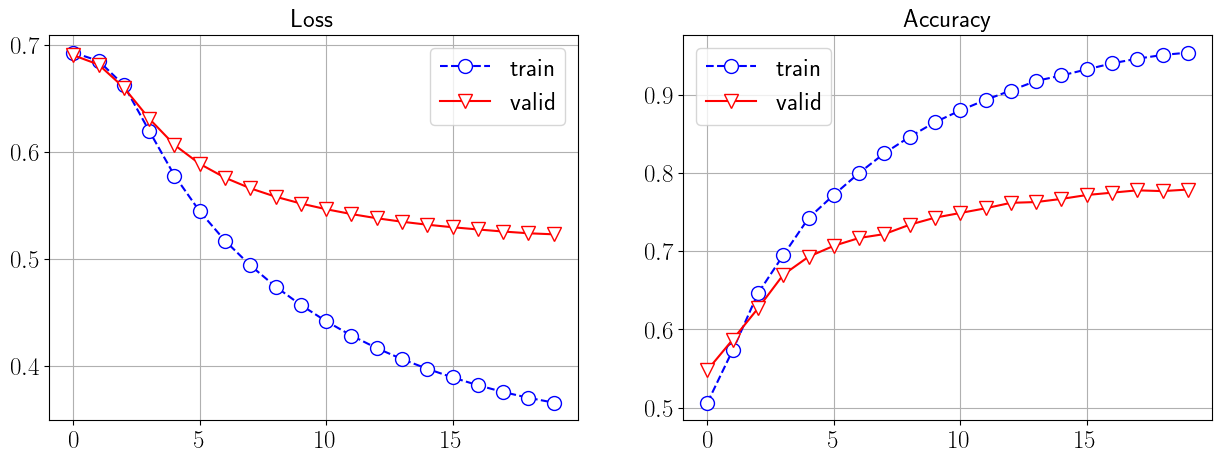

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
marker = ["o", "v"]
color = ["blue", "red"]
linestyle = ["--", "-"]
markerfacecolor = ["white", "white"]
markersize = 10
grid = True
ax[0].plot(epoch_train_losses, label="train", marker=marker[0], linestyle=linestyle[0],
           markerfacecolor=markerfacecolor[0], markersize=markersize, color=color[0])
ax[0].plot(epoch_val_losses, label="valid", marker=marker[1], linestyle=linestyle[1],
           markerfacecolor=markerfacecolor[1], markersize=markersize, color=color[1])
ax[0].set_title("Loss")
ax[0].grid(grid)
ax[0].legend()
ax[1].plot(epoch_train_accs, label="train", marker=marker[0], linestyle=linestyle[0],
           markerfacecolor=markerfacecolor[0], markersize=markersize, color=color[0])
ax[1].plot(epoch_val_accs, label="valid", marker=marker[1], linestyle=linestyle[1],
           markerfacecolor=markerfacecolor[1], markersize=markersize, color=color[1])
ax[1].set_title("Accuracy")
ax[1].legend()
ax[1].grid(grid)
plt.show()

## State of the art model

To have a better model, we should add convolution layers of different kernel size, as in the paper of Yoon Kim 2014.
We can use kernels of size 3, 5, and 7 for instance.

🚧 **TODO** 🚧

Write a bigger model, with various kernel sizes and verify if it gets a better accuracy.

